# Project 1: Facebook dataset (political ads)

**Team members: Ronald (leader) & MD Abdullah (assistant)**<br>

### About dataset
Source: https://www.kaggle.com/datasets/mrmorj/political-advertisements-from-facebook

*This database, updated daily, contains ads that ran on Facebook and were submitted by thousands of ProPublica users from around the world. We asked our readers to install browser extensions that automatically collected advertisements on their Facebook pages and sent them to our servers. We then used a machine learning classifier to identify which ads were likely political and included them in this dataset.*

The data file of the following columns:

**id**
post id number on facebook

**html**
HTML of the ad as collected by the Political Ad Collector

**political**
number of Political Ad Collector users who have voted that the ad is political

**not_political**
number of Political Ad Collector users who have voted that the ad is not political

**title**
ad title

**message**
ad content

**thumbnail**
link for a thumbnail of the profile image (of the advertiser)

**created_at**
date ad was first collected by the Political Ad Collector

**updated_at**
the most recent time that it got an impression OR the most recent time it was voted on

**lang**
language of the ad. always en-US


**images**
link for images included in the ad

**impressions**
number of times the ad has been seen by the Political Ad Collector

**political_probability**
calculated by the classifier. data only includes ads with a probability >=0.7

**targeting**
Facebook’s “Why am I seeing this?” disclosure provided to Political Ad Collector users

**suppressed**
value is false. suppressed ads are excluded from this data set because they were misclassified

**targets**
a parsed version of targeting

**advertiser**
the account that posted the ad

**entities**
named entities mentioned in the ad, extracted using software

**page**
the page that posted the ad

**lower_page**
the Facebook URL of the advertiser that posted the ad (the “page” column, lowercased)

**targetings**
an array of one or more of Facebook’s “Why am I seeing this?” disclosures provided to Political Ad Collector users

**paid_for_by**
for political ads, the entity listed in Facebook’s required disclosure as having paid for the ad

**targetedness**
an internal metric for estimating how granularly an ad is targeted

**listbuilding_fundraising_proba**
no description provided


In [1]:
# reference to the data
data_file = './data/fbpac-ads-en-US.csv'

## Imports and settings

In [2]:
# imports
from bs4 import BeautifulSoup
from collections import Counter
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment import SentimentIntensityAnalyzer
from scipy.stats import mannwhitneyu
from scipy.stats import spearmanr
from wordcloud import WordCloud
import collections
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import string
import time

# settings
pd.options.display.float_format = "{:.2f}".format

## Data loading

In [3]:
def load_data():
    # try load data from pickle file; if it does not exist, try load from .csv file; if that also fails, show an error
    loading_start_time = time.time() 
    try:
        # load pickle file
        print(f"loading data from pickle file...")
        df = pd.read_pickle(data_file.replace('.csv','.pkl'))
        print(f"data loaded (took {time.time() - loading_start_time:.1f} seconds)")
    except FileNotFoundError:
        try:
            print("  -> no pickle file found")
            print("loading data from csv file instead (can take a while)...")
            df = pd.read_csv(data_file)
            print(f"  -> data loaded (took {time.time() - loading_start_time:.1f} seconds)")
            # resave as .pkl file - this loads around 7 times faster on my machine
            print(f"  -> resaving it as .pkl file (for faster loading in the future)")
            df.to_pickle(data_file.replace('.csv','.pkl'))
            # save a preview of the data in an excel file, with just 100 rows 
            print(f"  -> saving a preview of the data as {data_file.replace('.csv','_preview.xlsx')}")
            df.head(100).to_excel(data_file.replace('.csv','_preview.xlsx'), index=False)
        except FileNotFoundError:
            print(f"\nERROR: data '{data_file}' does not exist.\nCheck if the file exists and if Jupyter is in the correct working directory")
    return df

df = load_data()

loading data from pickle file...
data loaded (took 3.3 seconds)


## Helper functions

In [4]:
def shorten_column_names(df, max_length=10):
    '''this function shortens long column names of the provide df -- used for visualization purposes'''
    df_temp = df.copy()
    df_temp.columns = [col[:max_length - 3] + '...' if len(col) > max_length else col for col in df_temp.columns]
    return df_temp

def remove_html_tags(message):
    '''clean up an ad message: remove tags and other irrelevant info'''
    # Examples of ad messages:
    #   Ex 1: "<p>BREAKING: Trump’s Department of the Interior plans to remove Endangered Species Act protections for gray wolves. Without these safeguards, gray wolf populations could decline across the country. We must fight back on this attack on our wildlife.</p>"
    #   Ex 2: "<p><span class="_5mfr"><span class="_6qdm">🚨</span></span><span class="_5mfr"><span class="_6qdm">🚨</span></span> RED ALERT: The Trump administration just released its "gag rule." <span class="_5mfr"><span class="_6qdm">🚨</span></span><span class="_5mfr"><span class="_6qdm">🚨</span></span></p><p> This rule will put the health care of 4 million people at risk, including 1.6 million Planned Parenthood patients. </p><p> Donate immediately to fight these dangerous attacks on reproductive health and rights.</p>"
    #   Ex 3: "<p>Friday night at <a class="profileLink" href="https://www.facebook.com/RoundupSaloonDallas/">The Round-Up Saloon and Dance Hall</a> in Dallas, <a class="profileLink" href="https://www.facebook.com/EqualityTexas/">Equality Texas</a> urged our members all across Texas to vote for <a class="profileLink" href="https://www.facebook.com/betoorourke/">Beto O'Rourke</a> for United States Senator. <a href="http://bit.ly/EQTXQueerTheVoteYall">http://bit.ly/EQTXQueerTheVoteYall</a> <a class="_58cn" href="https://www.facebook.com/hashtag/queerthevoteyall"><span class="_5afx"><span class="_58cl _5afz">#</span><span class="_58cm">QueerTheVoteYall</span></span></a></p>"    
    # remove HTML tags
    soup = BeautifulSoup(message, "html.parser")
    message_clean = soup.get_text(separator=' ')
    return message_clean

def tokenize_message(message):
    '''Turn a string into a list of tokens, where a token can be a word, a number, an emoji, etc'''
    # example stirng: 1037, "Why this Democrat is voting for a Republican  I am a lifelong Democrat who is voting for a Republican. Justin Thompson of Port Clyde is running for Maine House District 92, which includes the towns of Thomaston, Cushing, South Thomaston, St. George and Matinicus.  Thompson may be a Republican, but he is an honest man, one of the many hard-working fishermen whose boats we hear chugging out to sea at 5 a.m. all along the coast of Maine. As a lobsterman, he is truly free and inde ... pendent. I could not see Thompson ever being bought, as so many of our politicians are. I may not agree with some of his positions, but I know they are the well-thought out and fair assessments of a man with integrity.  Thompson recently wrote a letter to the Courier-Gazette in Rockland supporting a Democrat, Knox County Sheriff’s Office Chief Deputy Tim Carroll, for sheriff.  In this crazy world of partisanship, we need Thompson.  Kathleen Fox  St. George"  Won't you write one too?   https://bangordailynews.com/…/tuesday-may-15-2018-why-this…/
    # some characters could be informative tokens, like "!", "?", and "#" as they relate to the tone or type of message; make sure they will be separate tokens when .split() is applied
    message = message.replace('#', ' # ').replace('!', ' ! ').replace('?', ' ? ').replace('$', ' $ ')
    # remove remaining punctuation characters
    message = message.translate(str.maketrans('', '', '\"\'.,;:“”""‘’'))
    # return list with tokens
    return list(set(message.split()))

def generate_wordcloud(df_target, title, df_reference):
    target_tokens = [token for sublist in df_target['message_tokens'] for token in sublist]
    reference_tokens = [token for sublist in df_reference['message_tokens'] for token in sublist]

    # Create a dictionary with words that are relatively common in target compared to reference
    target_frequency = collections.Counter(target_tokens)
    reference_frequency = collections.Counter(reference_tokens)

    # Find the relative frequency of words in the target compared to the reference
    display_dict = {word: target_frequency[word] / (reference_frequency[word] + 1) for word in target_frequency.keys()}

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(display_dict)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

## Descriptive statistics
* Data summary including measures of centrality and dispersion 
* Distribution of the data (each numeric column)
* Relationships between features (numeric columns)

            COLUMN     TYPE  VALID CNT  MISSING CNT  UNIQUE CNT
0    not_political    int64     162324            0          70
1        political    int64     162324            0         165
2      impressions    int64     162324            0         581
3     targetedness  float64     112747        49577          13
4   listbuildin...  float64     152394         9930      111229
5   political_p...  float64     162324            0      138951
6             lang   object     162324            0           1
7       suppressed   object     162324            0           1
8      paid_for_by   object     112045        50279        8786
9       advertiser   object     124613        37711       12068
10      lower_page   object     159764         2560       12609
11            page   object     159764         2560       12617
12           title   object     162306           18       14087
13         targets   object     158117         4207       22925
14       thumbnail   object     162324  

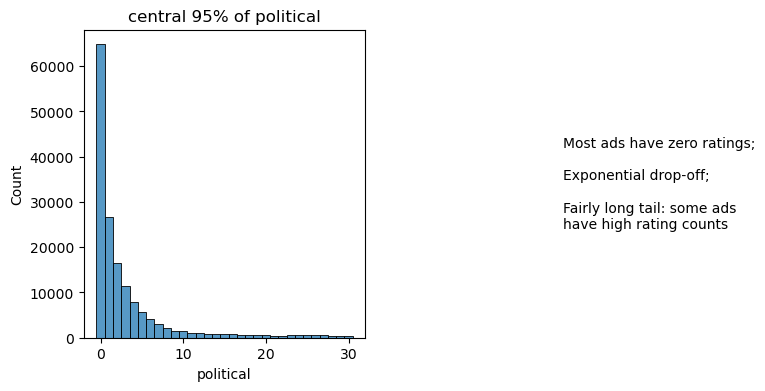

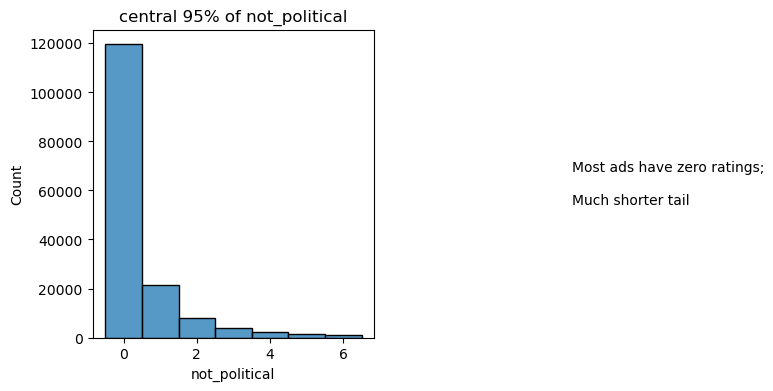

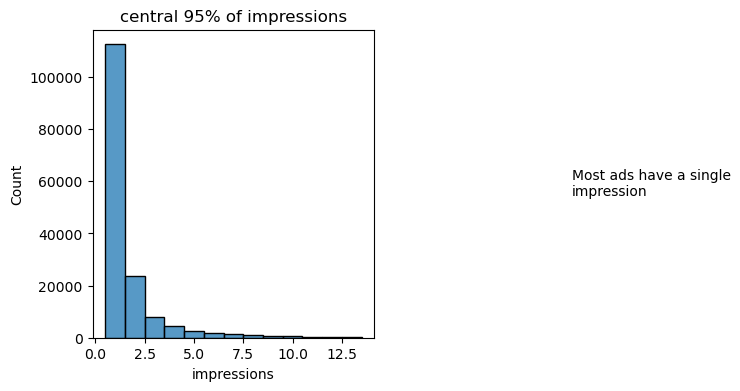

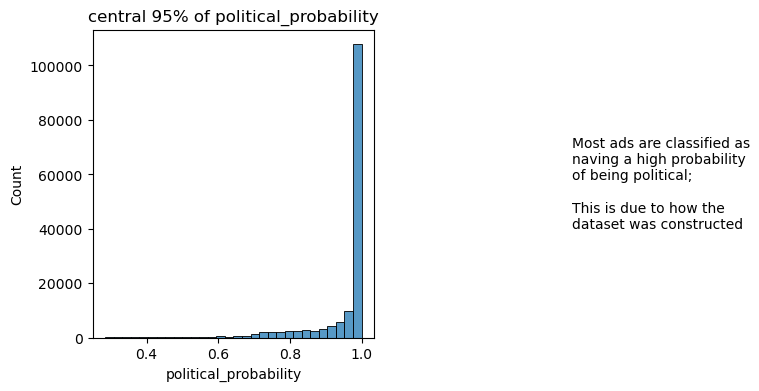

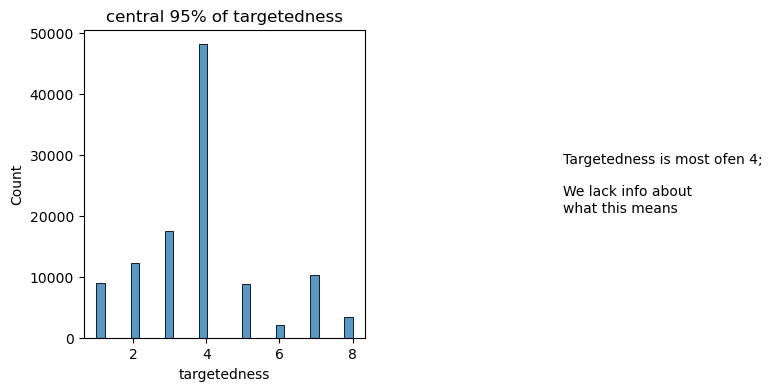

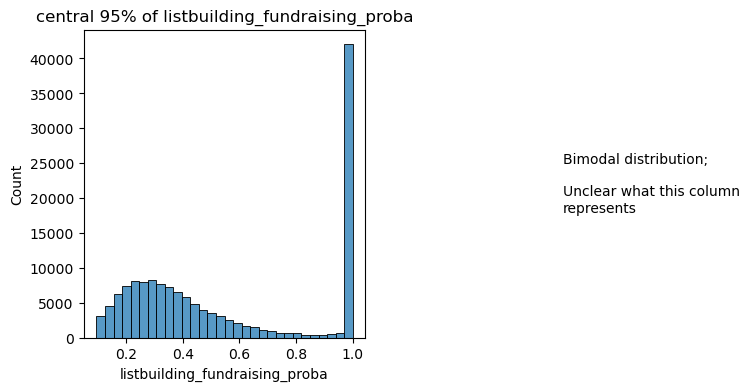

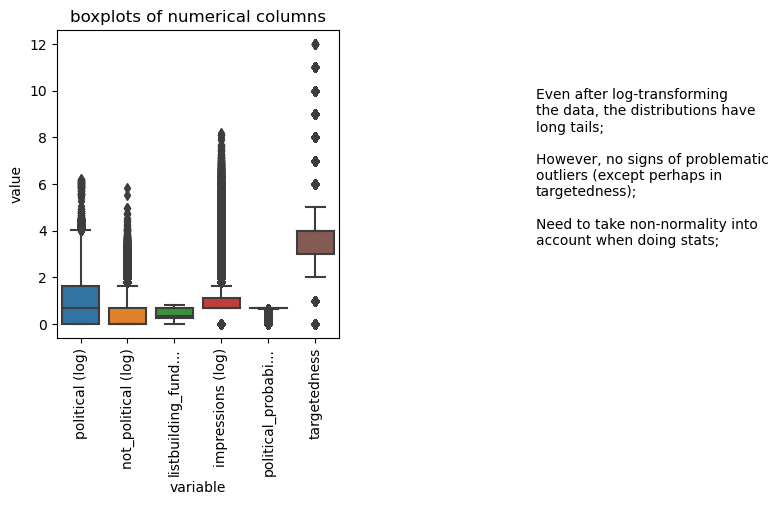

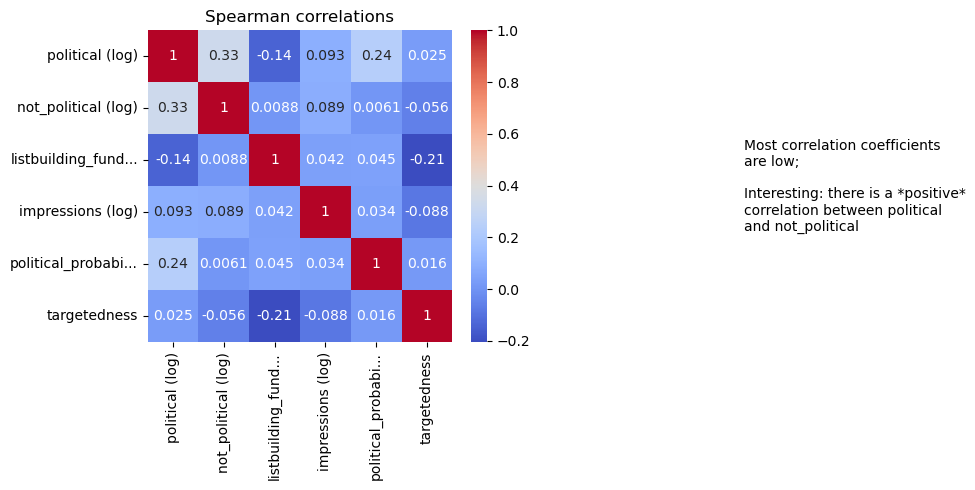


Top 5 strings in column 'id':
1. hyperfeed_story_id_5c9baa3ee0ec08073500042 (count=1)
2. hyperfeed_story_id_5c9f898b3bdfd7b36063574 (count=1)
3. 23843214878140078 (count=1)
4. hyperfeed_story_id_5c9f877d82b904058904185 (count=1)
5. hyperfeed_story_id_5c9f87edda5af4638937591 (count=1)

Top 5 strings in column 'html':
1. <div class="_5pcr userContentWrapper"><div class="_1dwg _1w_... (count=2)
2. <div class="_5pcr userContentWrapper"><div class="_1dwg _1w_... (count=2)
3. <div class="_5pa- userContentWrapper"><div class="_1dwg _1w_... (count=2)
4. <div class="_5pcr userContentWrapper"><div class="_1dwg _1w_... (count=2)
5. <div class="_5pcr userContentWrapper"><div class="_1dwg _1w_... (count=2)

Top 5 strings in column 'title':
1. International Rescue Committee (count=4150)
2. Planned Parenthood Action (count=2363)
3. Beto O'Rourke (count=2272)
4. Jay Inslee (count=1935)
5. Planned Parenthood (count=1849)

Top 5 strings in column 'message':
1. <p>It’s this simple: To get Jay to the deb

In [5]:
# build and show a summary of the data (shorten long column names to avoid wrapping in the visualization)
info_df = pd.DataFrame(index=shorten_column_names(df, 14).columns)
info_df['COLUMN'] = info_df.index
info_df['TYPE'] = df.dtypes.values
info_df['VALID CNT'] = df.count().values
info_df['MISSING CNT'] = df.isnull().sum().values
info_df['UNIQUE CNT'] = df.nunique().values
info_df = info_df.sort_values(['TYPE', 'UNIQUE CNT'])
info_df = info_df.reset_index(drop=True)
print(info_df)

#-------------- NUMERICAL COLUMNS --------------#

# show central tendency measures
print("\n### Measures of centrality and dispersion ###")
print(shorten_column_names(df, 14).describe().transpose())

# observations we made from the figures (for convenience of the reader, we put this info next to the figures)
observations = {}
observations['political'] = f"Most ads have zero ratings;\nExponential drop-off;\nFairly long tail: some ads\nhave high rating counts"
observations['not_political'] = f"Most ads have zero ratings;\nMuch shorter tail"
observations['impressions'] = f"Most ads have a single\nimpression"
observations['political_probability'] = f"Most ads are classified as\nnaving a high probability\nof being political;\nThis is due to how the\ndataset was constructed"
observations['targetedness'] = f"Targetedness is most ofen 4;\nWe lack info about\nwhat this means"
observations['listbuilding_fundraising_proba'] = f"Bimodal distribution;\nUnclear what this column\nrepresents"
observations['boxplot'] = f"Even after log-transforming\nthe data, the distributions have\nlong tails;\nHowever, no signs of problematic\noutliers (except perhaps in\ntargetedness);\nNeed to take non-normality into\naccount when doing stats;\n"
observations['correlation'] = f"Most correlation coefficients\nare low;\nInteresting: there is a *positive*\ncorrelation between political\nand not_political"

# show a histogram for each numerical column
tail_cut = 5  
num_cols = df.select_dtypes(include=['number']).columns
for col in num_cols:
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    lower = np.percentile(df[col].dropna(), tail_cut/2)
    upper = np.percentile(df[col].dropna(), 100-tail_cut/2)
    filtered_data = df[(df[col] >= lower) & (df[col] <= upper)][col]
    if np.issubdtype(filtered_data.dtype, np.integer):
        bins = np.arange(min(filtered_data) - 0.5, max(filtered_data) + 0.5, step=1)
    else:
        bins = 30
    sns.histplot(filtered_data, bins=bins, ax=axs[0])
    axs[0].set_title(f'central {100-tail_cut}% of {col}')    
    # add annotation
    if col in observations:
        axs[1].text(0.5, 0.5, observations[col].replace(";", ";\n"), ha='left', va='center', wrap=True)
    axs[1].axis('off') 
    plt.show()

# produce a boxplot to inspect outliers
num_cols_without_targetedness = list(set(num_cols)-set(['targetedness']))
df_transformed = df[num_cols_without_targetedness].apply(lambda x: np.log1p(x))
df_transformed['targetedness'] = df['targetedness']
df_transformed.rename(columns = dict(zip(num_cols_without_targetedness, [col_name + ' (log)' for col_name in num_cols_without_targetedness])), inplace=True)
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.boxplot(x="variable", y="value", data=pd.melt(shorten_column_names(df_transformed, 20)), ax=axs[0])
axs[0].set_title("boxplots of numerical columns")
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation='vertical')
if 'boxplot' in observations:
    axs[1].text(0.5, 0.5, observations['boxplot'].replace(";", ";\n"), ha='left', va='center', wrap=True)
axs[1].axis('off')  
plt.xticks(rotation='vertical')
plt.show()

# produce a correlation matrix
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
correlation_matrix = shorten_column_names(df_transformed, 20).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', ax=axs[0])
axs[0].set_title("Spearman correlations")
if 'correlation' in observations:
    axs[1].text(0.5, 0.5, observations['correlation'].replace(";", ";\n"), ha='left', va='center', wrap=True)
axs[1].axis('off')  
plt.tight_layout()
plt.show()

#-------------- STRING COLUMNS --------------#

# for string columns, show the top-5 most frequent string, to give an impression of the column contents
str_cols = df.select_dtypes(include=['object']).columns
for col in str_cols:
    top_counts = df[col].value_counts().nlargest(5)
    print(f"\nTop 5 strings in column '{col}':")
    for i, (the_string, the_count) in enumerate(top_counts.iteritems(), start=1):
        clipped_string = (the_string[:60] + '...') if len(the_string) > 60 else the_string
        print(f"{i}. {clipped_string} (count={the_count})")
    


## Observations

#### **General**
* The dataset consists of around 160k samples
* Each sample contains various kinds of information about a specific facebook ad
* 17 of the 23 columns contain string data, most of which do not seem particularly interesting from an analysis perspective
* Potentially interesting data for analysis are the following columns:
  * political, not_political: counts of how often the ad was perceived as political / non-political
  * message: the text contents of the message
  * advertiser: the person or organization that posted the ad
* Columns *targetedness* and *listbuilding_fundraising_proba* are potentially interesting too, but it is unclear what these data represent
* Column *political_probability* may *seem* interesting, but it is a derived column (not raw data) and it is unclear how it was computed; we will ignore it

#### **Outliers and data cleanliness**
* The columns that we selected for further analysis have no missing data
* Those columns show no signs of problematic outliers and appear to be are largely clean (except *messages*: see below)

#### **Some notes regarding the *messages* column**
* The *message* data contain html tags, which we should remove because they are unlikely to be informative in any analyses we will perform
* While the *message* column holds 162k strings, only 73k of them are unique
  * This means that some messages are duplicated, i.e., the same ad appears in multiple rows
  * We will aggregate these and sum the counts in *political* and *not_political*
* To perform analysis on this column, it will be good to tokenize each message into a list of words
* We remove all rows from the dataframe in which the list of tokens is empty

## Potential research question(s)
One very interesting aspect of this dataset is that it allows us to examine what it is that makes people judge some ads as 'political' and others as 'non-political'. 

We could for example focus on the following two question:
1. Are the political/not-political ratings triggered by certain words?
2. Are these ratings related to certain sentiments?

To investigate this, we could focus on the following variables:
* political: the number of times that an ad was flagged as political
* not_political: the number of times that an ad was flagged as non-political
* message: the contents of the ad

In the remaining steps, we will ignore all other variables.

## Exploratory Data Analysis (EDA):
* Identify the variables and their types 
* Clean the data (address errors, duplicates, missing values, outliers)
* Transformation (standardization, normalization, encoding categorical to numerical)
* Data Visualization (use the suitable visualization that you need)


### Measures of centrality and dispersion after data preprocessing ###
                  count  mean   std  min  25%  50%  75%     max
political      72787.00  9.32 26.70 0.00 0.00 2.00 8.00 1673.00
not_political  72787.00  1.77  8.21 0.00 0.00 0.00 1.00  604.00
political_log  72787.00  1.39  1.25 0.00 0.00 1.10 2.20    7.42
not_politic... 72787.00  0.45  0.78 0.00 0.00 0.00 0.69    6.41

55752 out of 72787 ads received at least 1 political or not_political vote


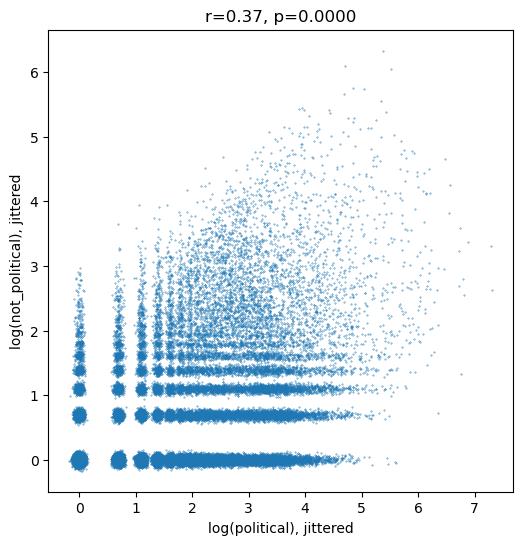

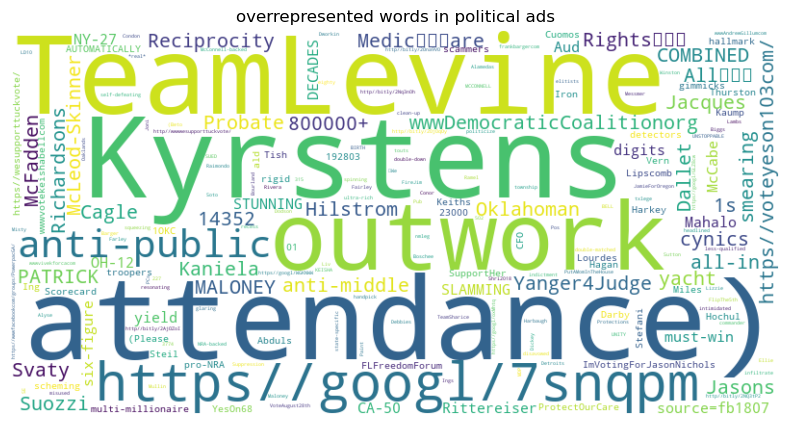

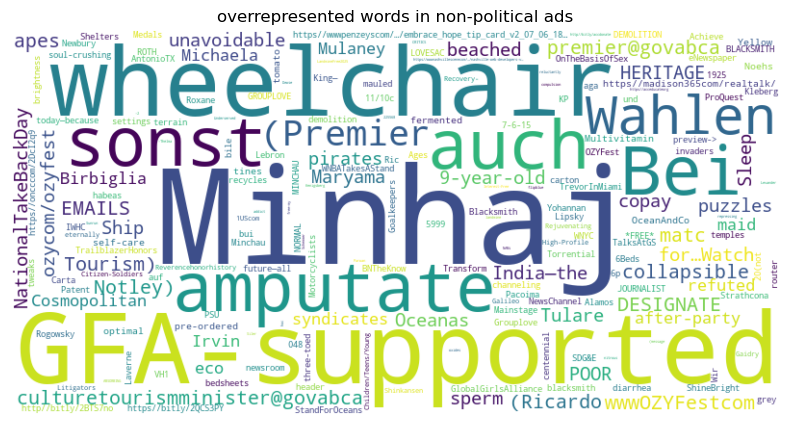

In [6]:
# drop all columns except 'political', 'not_political', and 'message'
df = df[['political', 'not_political', 'message']]

# the descriptive stats showed that some of the ad messages are duplicated (73k unique out ouf 162k rows); combine those:
df = df.groupby('message').agg({'political': 'sum', 'not_political': 'sum'}).reset_index()

# log-transform the counts, as these follow exponential distributions (see earlier histograms); to do: check if this really makes a difference
df['political_log'] = np.log1p(df['political'])
df['not_political_log'] = np.log1p(df['not_political'])

# show central tendency measures of cleaned and transformed data
print("\n### Measures of centrality and dispersion after data preprocessing ###")
print(shorten_column_names(df, 14).describe().transpose())

# count the number of ads that received no 'politicalness' votes at all
print(f"\n{((df['political'] + df['not_political'])>0).sum()} out of {df.shape[0]} ads received at least 1 political or not_political vote")

# further investigate the earlier observed correlation between 'political' and 'non-political' 
r, p = spearmanr(df['political_log'], df['not_political_log'])
political_log_jittered = df['political_log'] + np.random.normal(0, 0.04, size=len(df['political_log']))
nonpolitical_log_jittered = df['not_political_log']  + np.random.normal(0, 0.04, size=len(df['not_political_log']))
plt.figure(figsize=(6, 6))
plt.scatter(x=political_log_jittered, y=nonpolitical_log_jittered, s=0.1, edgecolor=None)
plt.title(f"r={r:.2f}, p={p:.4f}")
plt.xlabel("log(political), jittered")
plt.ylabel("log(not_political), jittered")
plt.show()

# remove tags from the messages and split them into tokens (words and certain punctuation marks)
df['message_no_tags'] = df['message'].apply(remove_html_tags)
df['message_tokens'] = df['message_no_tags'].apply(tokenize_message)

# generate raw word clouds
generate_wordcloud(df[(df['political'] > 0) & (df['not_political'] == 0)], 'overrepresented words in political ads', df)
generate_wordcloud(df[(df['political'] == 0) & (df['not_political'] > 0)], 'overrepresented words in non-political ads', df)


## Observations from the EDA
* We have around 56k ads with at least one rating on either 'political' or 'not_political', which gives us a good amount of data for the planned analyses
* Surprisingly, there is a *positive* correlation between 'political' and 'not_political' counts; this could mean that some words trigger some people to flag an ad as 'not political' while they trigger others to flag it as 'not political'
* The word clouds aren't extremely helpful yet for the research questions - they suggest that some ads have been included in a lot of different variations in this dataset (e.g.: "TeamLevine" and "https//googl/7snqpm") - this may be bad news, because it could mean that we actually have quite a limited dataset (many samples, but with many repeats of similar ads)

## Sentiment analysis


Removed 15 rows with len(message_tokens) < 1
Computing sentiment scores - can take a minute or two


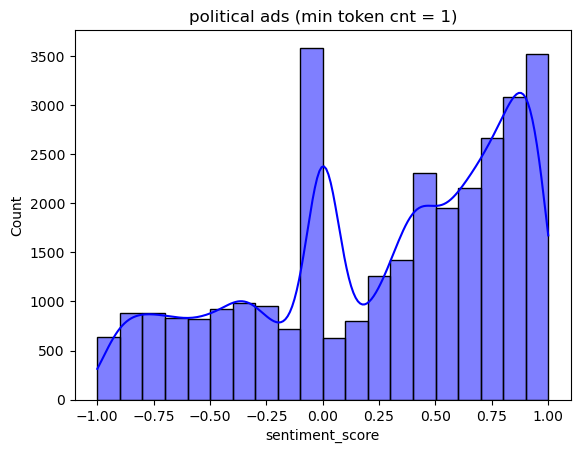

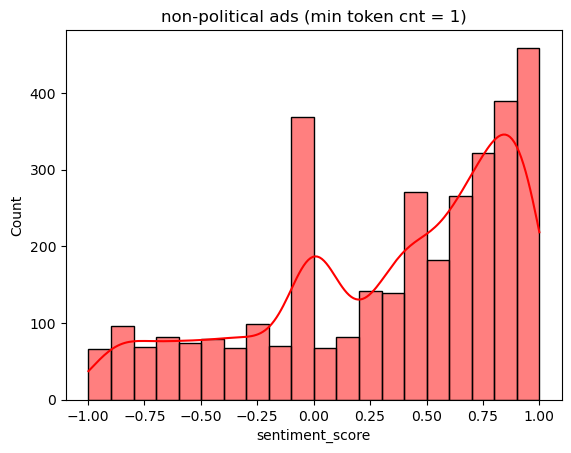

Mean sentiment scores: 0.27 (political), 0.33 (non-political)
Mann-Whitney t-test: U=48753533.000, p=0.000


In [7]:
def sentiment_analysis(min_token_cnt = 1):
    # make a copy of the df and remove all rows in which the message has too few tokens
    df_copy = df.copy()
    df_copy = df_copy[df_copy['message_tokens'].apply(len) >= min_token_cnt]
    print(f"\nRemoved {df.shape[0] - df_copy.shape[0]} rows with len(message_tokens) < {min_token_cnt}")

    # compute a sentiment score for each ad
    print(f"Computing sentiment scores - can take a minute or two")
    sid = SentimentIntensityAnalyzer()
    df_copy['sentiment_score'] = df_copy['message_no_tags'].apply(lambda x: sid.polarity_scores(x)['compound'])

    # plot sentiment score distributions for 'political' > 0
    sns.histplot(df_copy[(df_copy['political'] > 0) & (df_copy['not_political'] == 0)]['sentiment_score'], bins=20, kde=True, color='blue')
    plt.title(f"political ads (min token cnt = {min_token_cnt})")
    plt.show()

    # plot sentiment score distributions for 'not_political' > 0
    sns.histplot(df_copy[(df_copy['political'] == 0) & (df_copy['not_political'] > 0)]['sentiment_score'], bins=20, kde=True, color='red')
    plt.title(f"non-political ads (min token cnt = {min_token_cnt})")
    plt.show()

    # perform Mann-Whitney U test to check if the average sentiment score differs between 'political' and 'not_political'
    political_sentiment_scores = df_copy[(df_copy['political'] > 0) & (df_copy['not_political'] == 0)]['sentiment_score']
    not_political_sentiment_scores = df_copy[(df_copy['political'] == 0) & (df_copy['not_political'] > 0)]['sentiment_score']
    u_stat, p_value = mannwhitneyu(political_sentiment_scores, not_political_sentiment_scores)
    print(f"Mean sentiment scores: {political_sentiment_scores.mean():.2f} (political), {not_political_sentiment_scores.mean():.2f} (non-political)")
    print(f"Mann-Whitney t-test: U={u_stat:.3f}, p={p_value:.3f}")

sentiment_analysis()

## Observations
* Sentiments are generally positive for both political and non-political ads
* The t-test indicates a difference (political ads are slightly less positive than non-political ones), but the effect size is relatively small
* There is a big peak at 0 for both groups of ads, which should be further investigated
  * This peak possibly reflects a group of ads in which the message is very short, which should make sentiment analysis difficult (if not meaningless)
  * To test this we rerun the analysis with different threholds on the minimum number of message tokens


Removed 3063 rows with len(message_tokens) < 10
Computing sentiment scores - can take a minute or two


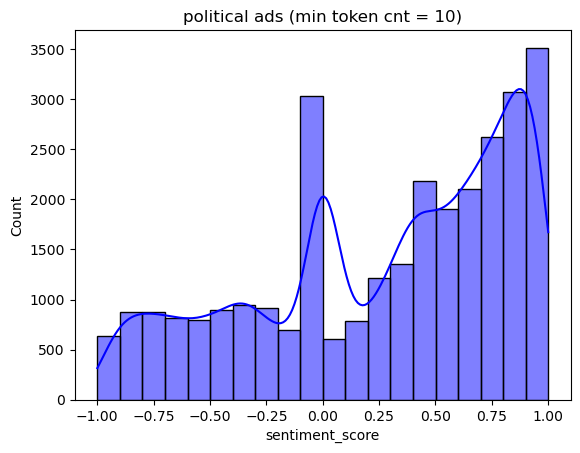

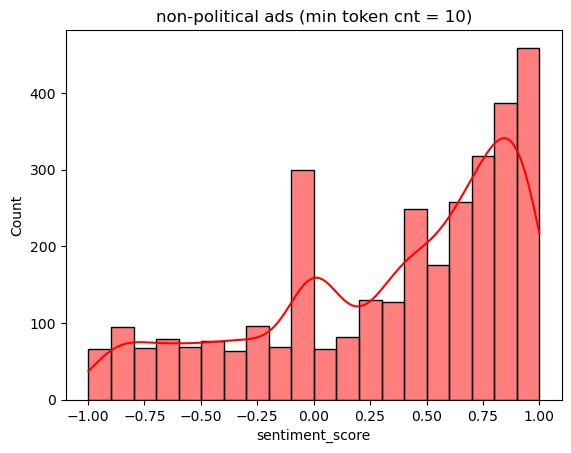

Mean sentiment scores: 0.27 (political), 0.34 (non-political)
Mann-Whitney t-test: U=44599371.500, p=0.000

Removed 28544 rows with len(message_tokens) < 25
Computing sentiment scores - can take a minute or two


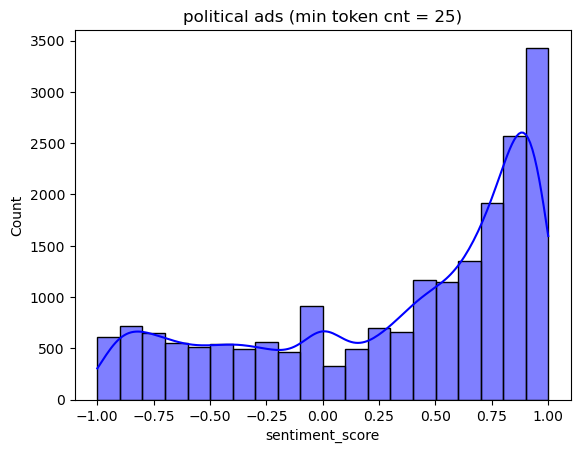

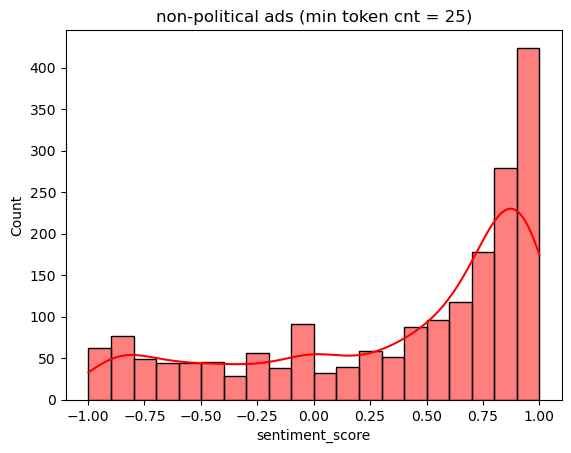

Mean sentiment scores: 0.33 (political), 0.38 (non-political)
Mann-Whitney t-test: U=17308080.000, p=0.000

Removed 58647 rows with len(message_tokens) < 50
Computing sentiment scores - can take a minute or two


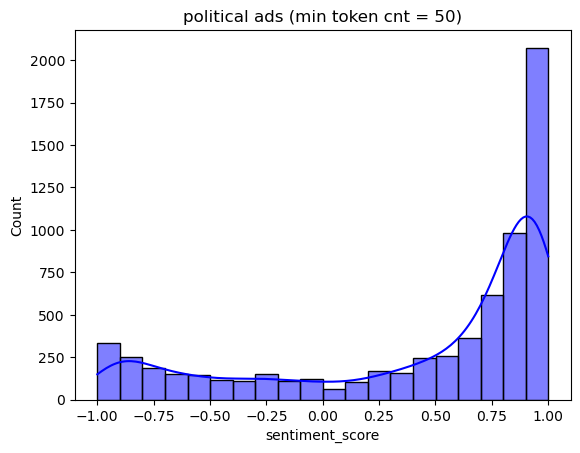

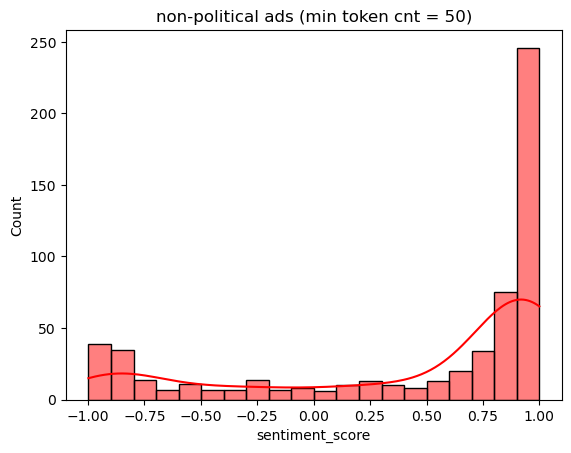

Mean sentiment scores: 0.43 (political), 0.45 (non-political)
Mann-Whitney t-test: U=1722573.500, p=0.000


In [8]:
sentiment_analysis(10)
sentiment_analysis(25)
sentiment_analysis(50)

# Conclusions

#### **Word clouds**
* The word clouds suggest that there are some words that are typical for ads that the raters consider 'political' and other words that are typical for ads that raters consider 'non-political'. However:
  * The identified words seem very specifically linked to very specific advertisers (e.g.: "TeamLevine" and "https//googl/7snqpm")
  * In other words, some advertisers may be overrepresented in this dataset, which could create biases if we would for example train a classifier on these data
  * To make results generalizable, it would be advisable to reduce that kind of bias by collecting more data (create more diversity) or applying methods like re-sampling or cost-sensitive analysis
  
#### **Sentiment analysis**
* The sentiment analysis suggest that both political and non-political ads are generally frame in a positive way; therefore, sentiment scores might not be very useful for classifying political vs non-political ads

#### **Other**
* There is a positive correlation between number of times that an ad was rated as 'political' and number of times an ad was rated as non-political. This is unexpected, because if 'political' and 'non-political' have opposite meanings, then one would expect a *negative* correlation. This is worth further investigation.

# Appendix: distribution of advertizers
Out of curiosity, I had a look at the distribution of advertisers. As the result below indicates, there are indeed a few advertisers that occur very often in the data, which likely biases the data.

loading data from pickle file...
data loaded (took 3.9 seconds)


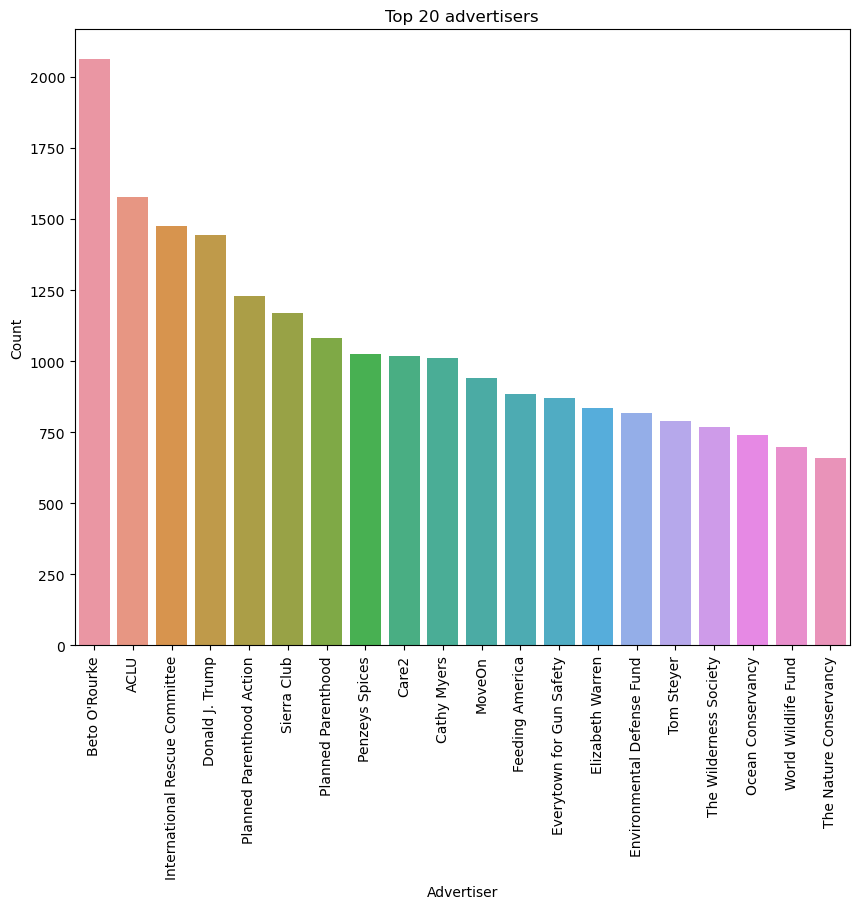

In [9]:
# make a histogram with top 20 most frequent advertisers
df = load_data()
top_advertisers = df['advertiser'].value_counts().nlargest(20)
plt.figure(figsize=(10, 8))
sns.barplot(x=top_advertisers.index, y=top_advertisers.values)
plt.title('Top 20 advertisers')
plt.xlabel('Advertiser')
plt.ylabel('Count')
plt.xticks(rotation=90) 
plt.show()